In [1]:
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

2023-06-01 19:11:25.447378: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 19:11:25.478950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 19:11:25.479322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 19:11:26.313045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATASET_PATH = '/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset_1'

In [3]:
pair_ims = []
labels = []

In [4]:
im_path_arr = os.listdir(DATASET_PATH)
im_classes_arr = []

for file in im_path_arr:
    im_classes_arr.append(file.split('_')[0])

im_classes_arr = np.asarray(im_classes_arr)

In [5]:
classes = np.unique(im_classes_arr)

In [6]:
dict_keys = {val:key for key, val in enumerate(classes.flatten())}
dict_keys

{'ba': 0,
 'bajafresh': 1,
 'bcdp': 2,
 'becel': 3,
 'belvitas': 4,
 'bf': 5,
 'bifi': 6,
 'bn': 7,
 'bndts': 8,
 'bv': 9,
 'carling': 10,
 'cassano': 11,
 'cavalier': 12,
 'cc': 13,
 'cd': 14,
 'cfk': 15,
 'chandelle': 16,
 'chattime': 17,
 'chickenexpre': 18,
 'chocomel': 19,
 'cinnezo': 20,
 'cjr': 21,
 'cocacola': 22,
 'cocio': 23,
 'cp': 24,
 'cr': 25,
 'mcd': 26}

In [7]:
grouped_im_path = [np.where(im_classes_arr == cls)[0] for cls in classes]

In [8]:
im_path_arr[121], im_path_arr[142]

('mcd_30.jpg', 'mcd_11.jpg')

In [9]:
np.random.choice(np.where(im_classes_arr != 'belvitas')[0], 1)[0]

49

In [10]:
for file in im_path_arr:
    file_cls = file.split('_')[0]
    cls = dict_keys[file_cls]

    current_im = cv.imread(os.path.join(DATASET_PATH, file))
    current_im = cv.cvtColor(current_im, cv.COLOR_BGR2RGB)
    current_im = cv.resize(current_im, (128, 128))
    current_im = current_im / 255

    pos_idx = np.random.choice(grouped_im_path[cls], 1)[0]
    pos_pair_im = cv.imread(os.path.join(DATASET_PATH, im_path_arr[pos_idx]))
    pos_pair_im = cv.cvtColor(pos_pair_im, cv.COLOR_BGR2RGB)
    pos_pair_im = cv.resize(pos_pair_im, (128, 128))
    pos_pair_im = pos_pair_im / 255

    pair_ims.append((current_im, pos_pair_im))
    labels.append(1)

    neg_idx = np.random.choice(np.where(im_classes_arr != file_cls)[0], 1)[0]
    neg_pair_im = cv.imread(os.path.join(DATASET_PATH, im_path_arr[neg_idx]))
    neg_pair_im = cv.cvtColor(neg_pair_im, cv.COLOR_BGR2RGB)
    neg_pair_im = cv.resize(neg_pair_im, (128, 128))
    neg_pair_im = neg_pair_im / 255

    pair_ims.append((current_im, neg_pair_im))
    labels.append(0)

In [11]:
np_ims = np.asarray(pair_ims)
np_labels = np.asarray(labels)

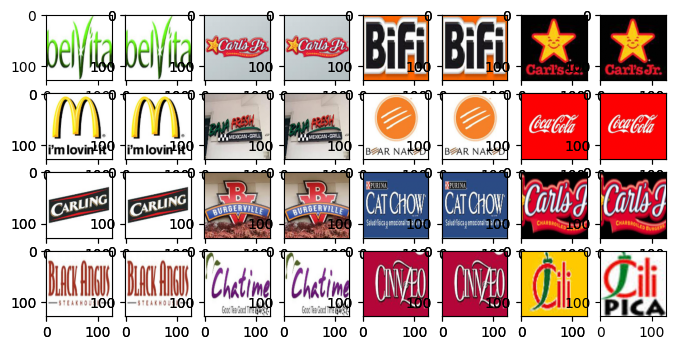

In [12]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for index, i in enumerate(range(1, (columns*rows +1)//2)):
    img =   np_ims[index][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    img =   np_ims[index][1]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [13]:
IMG_SHAPE = (128, 128, 3)
BATCH_SIZE = 4
EPOCHS = 100

In [14]:
class SiameseModel:

    def __init__(self, input_shape, embedding_dim=256):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim

    def _build(self):
        inputs = tf.keras.layers.Input(self.input_shape)
        
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
        x = tf.keras.layers.MaxPooling2D()(x)

        x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D()(x)

        x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(.2)(x)

        pooled_output = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(self.embedding_dim)(pooled_output)

        model = tf.keras.Model(inputs, outputs)

        return model

In [15]:
sm = SiameseModel(IMG_SHAPE)

featureExtractor = sm._build()
featureExtractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               8448  

2023-06-01 19:11:33.408779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 19:11:33.409195: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [17]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [18]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = tf.keras.layers.Input(shape=IMG_SHAPE)
imgB = tf.keras.layers.Input(shape=IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [19]:
# finally, construct the siamese network
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 256)          9344        ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

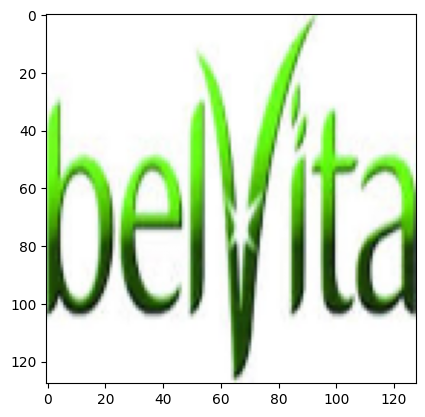

In [21]:
plt.imshow(np_ims[1][0])

In [22]:
# compile the model
tf.keras.backend.clear_session()

print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[np_ims[:251, 0], np_ims[:251, 1]], np_labels[:251],
	validation_data=([np_ims[251:, 0], np_ims[251:, 1]], np_labels[251:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
63/63 [==============================] - 2s 25ms/step - loss: 0.6845 - accuracy: 0.5578 - val_loss: 0.6814 - val_accuracy: 0.6154
Epoch 2/100
63/63 [==============================] - 1s 22ms/step - loss: 0.6781 - accuracy: 0.5936 - val_loss: 0.6738 - val_accuracy: 0.6294
Epoch 3/100
63/63 [==============================] - 1s 22ms/step - loss: 0.6729 - accuracy: 0.5936 - val_loss: 0.6641 - val_accuracy: 0.6364
Epoch 4/100
63/63 [==============================] - 1s 22ms/step - loss: 0.6652 - accuracy: 0.6135 - val_loss: 0.6696 - val_accuracy: 0.6364
Epoch 5/100
63/63 [==============================] - 1s 22ms/step - loss: 0.6576 - accuracy: 0.6215 - val_loss: 0.6547 - val_accuracy: 0.6713
Epoch 6/100
63/63 [==============================] - 1s 22ms/step - loss: 0.6573 - accuracy: 0.6733 - val_loss: 0.6510 - val_accuracy: 0.6713
Epoch 7/100
63/63 [==============================] - 1s 22ms/step - loss: 0.6535 - accuracy: 0.68